In [171]:
# Tools 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Vistazo a los datos 

Primero leamos los datos y busquemos si hay datos faltantes.

In [172]:
df = pd.read_csv('./penguins.csv')
df = df[df['species'] != 'Chinstrap']
df = df.drop(['rowid', 'island', 'sex', 'year'], axis=1)
df['species'] = df['species'].astype('category')
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 275
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   species            276 non-null    category
 1   bill_length_mm     274 non-null    float64 
 2   bill_depth_mm      274 non-null    float64 
 3   flipper_length_mm  274 non-null    float64 
 4   body_mass_g        274 non-null    float64 
dtypes: category(1), float64(4)
memory usage: 11.2 KB


Como podemos ver existen valores nulos en el dataset, para gestionar estos datos faltantes vamos a imputarlos usando k-NN.

In [174]:
# Gestionamos los datos faltantes (valores NaN)
X = df.iloc[:, 1:]
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)
df.iloc[:, 1:] = X

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 275
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   species            276 non-null    category
 1   bill_length_mm     276 non-null    float64 
 2   bill_depth_mm      276 non-null    float64 
 3   flipper_length_mm  276 non-null    float64 
 4   body_mass_g        276 non-null    float64 
dtypes: category(1), float64(4)
memory usage: 11.2 KB


Veamos si las clases en las que estamos interesados estan balancedas. 

/Users/sergio/anaconda3/envs/machine_lr/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


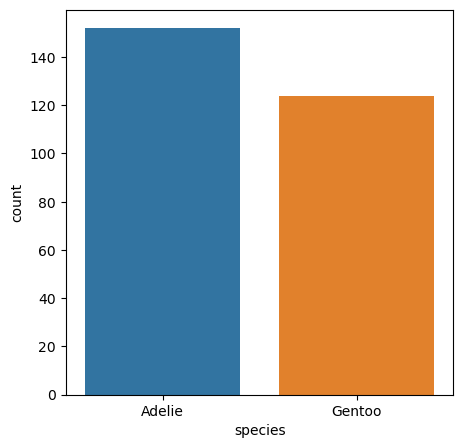

In [177]:
plt.figure(figsize=(5, 5))
sns.countplot(x = df["species"])
plt.show()

Ahora, usemos PCA para visualizar los datos en dos dimensiones y explorar la viabilidad de usar algún algoritmo para clasificar como LDA.

In [178]:
# Visualicemos los datos con PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, 1:])

pca = PCA(n_components=2)
df_proy = pca.fit_transform(df_scaled)

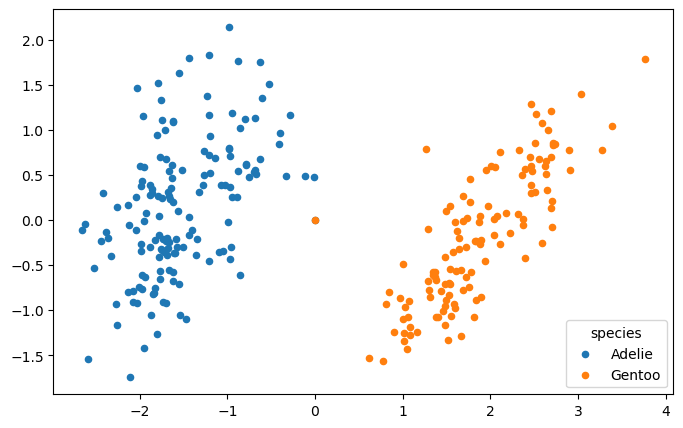

In [180]:
# Visualizamos clusters en 2D 

plt.figure(figsize=(8, 5))
for specie in df["species"].unique():
    labels = df["species"] == specie
    plt.scatter(df_proy[labels, 0], df_proy[labels, 1], marker='o', s=20, label=str(specie))

plt.legend(title='species')
plt.tight_layout
plt.show()

En la gráfica se muestra de manera contundente que hay evidencia de que los datos se dividen principalmente en dos grupos, los cuáles se corresponden con la especie. A continuación desplegaremos diferentes algoritmos de clasificación, para ello primero hagamsos un split a los datos en un cojunto de entrenamiento y validación.

In [181]:
# Split a los datos 
X_train, X_test, y_train, y_test = train_test_split(df.drop('species', axis=1), df['species'], test_size=0.2, random_state=42)

### LDA

In [182]:
# Hacemos LDA

# Creamos el modelo 
lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)
mi_lda = lda.fit(X_train, y_train)

# Imprimimos los predictores 
print(lda.scalings_)

[[ 0.11898728]
 [-0.96807874]
 [ 0.07452956]
 [ 0.00099023]]


Podemos ver de los coeficientes de los predictores que el algoritmo le da una mayor importancia a la longitud del pico del pinguino. 

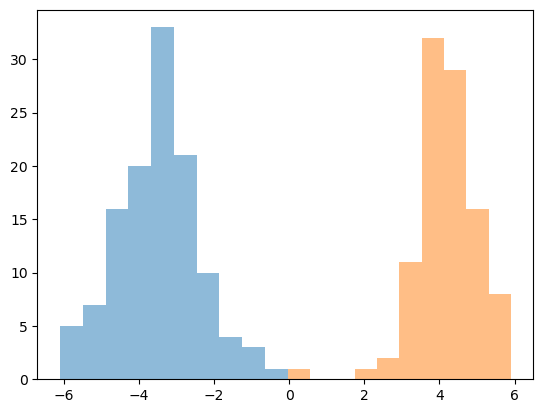

In [183]:
# Proyectamos los datos 
PX_train = lda.transform(X_train)
plt.hist(PX_train[y_train[:]=='Adelie'],  alpha=0.5, label='x')
plt.hist(PX_train[y_train[:]=='Gentoo'],  alpha=0.5, label='x')
plt.show()

Como era de esperarse, proyectar sobre la recta definida por los valores de LDA de scaling, los datos siguen una ditribución normal. A continuación se muestra el reporte de la calidad de clasificación, mostrando un accuracy de aproximadamente 100%

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        32
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



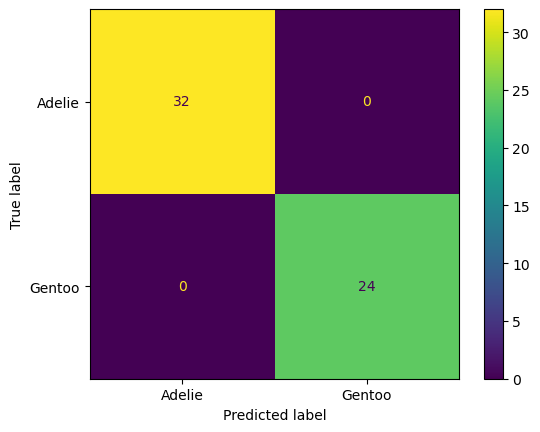

In [184]:
# Predict and evaluate 
y_pred = mi_lda.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

ConfusionMatrixDisplay.from_estimator(mi_lda, X_test, y_test)
plt.show()

### Naive Bayesian Classifier 

Ahora consideremos el clasificador Bayesiano Ingenúo, para esto primero calculemos las probabilidades a priori y las probabilidades condicionales. 

In [186]:
# Calculate prior probabilities
prior_probabilities = df['species'].value_counts(normalize=True)

# Calculate conditional probabilities
def conditional_probability(df, feature, target, target_value):
    subset = df[df[target] == target_value]
    return subset[feature].value_counts(normalize=True)

# Store probabilities in a dictionary for easy lookup
probabilities = {}
for target_value in df['species'].unique():
    probabilities[target_value] = {}
    probabilities[target_value]['prior'] = prior_probabilities[target_value]
    for feature in df.columns[1:]:  # Exclude the target column
        probabilities[target_value][feature] = conditional_probability(df, feature, 'species', target_value)

Una vez teniendo las probabilidades calculadas, podemos predecir la clase a partir de los datos. 

In [187]:
def predict(row, probabilities):
    outputs = {}
    for target_value in probabilities.keys():
        prob = probabilities[target_value]['prior']
        for feature in row.index:
            feature_prob = probabilities[target_value][feature].get(row[feature], 1e-5)  # Smoothing for unseen features
            prob *= feature_prob
        outputs[target_value] = prob
    return max(outputs, key=outputs.get)

# Prediction on test set
y_pred = X_test.apply(lambda row: predict(row, probabilities), axis=1)
print(confusion_matrix(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))


[[32  0]
 [ 0 24]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        32
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



Cómo podemos ver, se obtiene un accuracy de 1, clasificando todos los datos correctamente. 

### k-NN Clasificador 

Ahora usemos un esquema de k-NN como clasificador, el número de vecinos a considerar es crusial en este algoritmo, por lo tanto primero probemos distintos valores de k y calculemos el accuracy para cada caso, los resultados se muestran en la figura de abajo. 

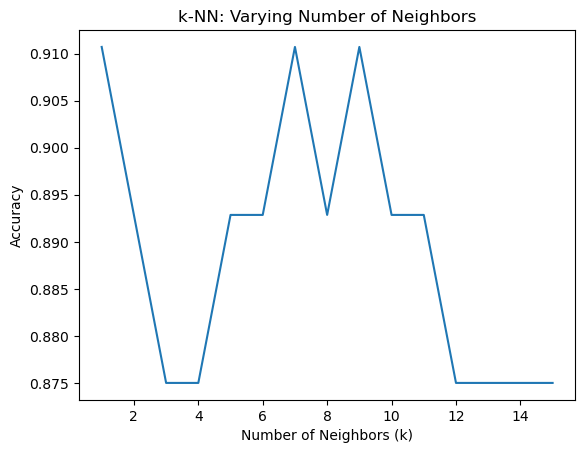

In [188]:
# Testing from 1 to 15 neighbors
accuracies = []
for i in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_test, y_test))

# Plot results
plt.plot(range(1, 16), accuracies)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('k-NN: Varying Number of Neighbors')
plt.show()


Vemos que el accuracy varía demasiado dependiendo del parámetro k, pero basta considerar k=1 para obtener un buen rendimiento logrando un accuracy del 91%, a continuación se muestra el reporte del clasificador. 

              precision    recall  f1-score   support

      Adelie       0.89      0.97      0.93        32
      Gentoo       0.95      0.83      0.89        24

    accuracy                           0.91        56
   macro avg       0.92      0.90      0.91        56
weighted avg       0.91      0.91      0.91        56



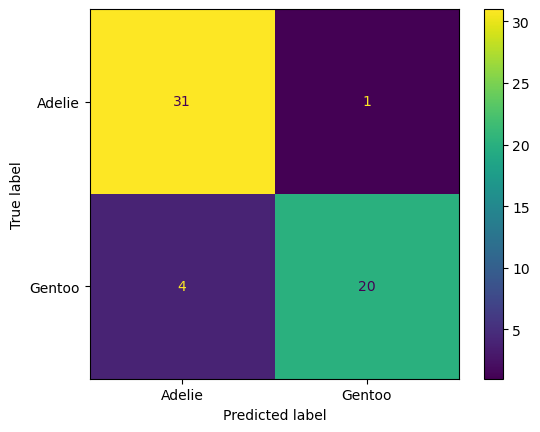

In [189]:
# Choose 1-NN 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Preedict and evaluate 
y_pred = knn.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.show()

### LR

Finalmente usemos regresión logística. A continuación se muestran los coeficientes del modelo lineal, recordemos que estos parámetros tienen que ver con cuanto aumenta la probabilidad de ser de una clase o la otra, dada una observación, todo esto en escala logarítmica. Para este clasificador obtenemos un accuracy de 1. 

In [190]:
# Create model 
RL = LogisticRegression()
mi_RL=RL.fit(X_train, y_train)
print(mi_RL.coef_)

[[ 0.32877149 -1.23901469  0.24612021  0.00419178]]


              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        32
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



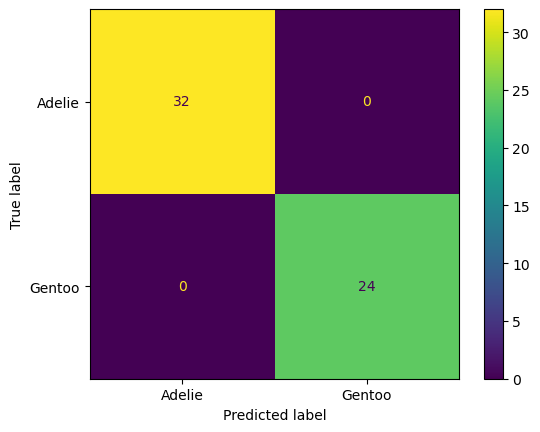

In [191]:
# Predict and evaluate 
y_pred = mi_RL.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

ConfusionMatrixDisplay.from_estimator(mi_RL, X_test, y_test)
plt.show()

### Regresión logística: Adelie y Chinstrap

Por último, hagamos regresión logística con las especies Adelie, Chinstrap, para este caso vamos a usar la API de statsmodels, la cuál nos ofrece información estadística útil. 

In [192]:
# Cargamos statsmodels 
import statsmodels.api as sm
import statsmodels.formula.api as smf

Para este ejercicio seleccionemos a las especies Adelie y Chinstrap 

In [193]:
# Read again data 
df = pd.read_csv('./penguins.csv')
df = df.drop(['rowid', 'island', 'sex', 'year'], axis=1)
X = df.iloc[:, 1:]
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)
df.iloc[:, 1:] = X
selected_species = ['Adelie', 'Chinstrap']
df_subset = df[df['species'].isin(selected_species)]

# Split a los datos 
X_train, X_test, y_train, y_test = train_test_split(df_subset.drop('species', axis=1), df_subset['species'], test_size=0.2, random_state=42)


Para este modelo obtenemos un deviance de 186.3 y un número de grados de libertad de 172, lo cuál nos nos indica que hay evidencia estadística de que el modelo se ajusta a los datos razonablemente. 

In [205]:
data_train = pd.DataFrame({"y" : y_train,
                "x1" : X_train.iloc[:,0],
                "x2" : X_train.iloc[:,1], 
                "x3" : X_train.iloc[:,2], 
                "x4" : X_train.iloc[:,3]})

data_test = pd.DataFrame({"y" : y_test,
                "x1" : X_test.iloc[:,0],
                "x2" : X_test.iloc[:,1], 
                "x3" : X_test.iloc[:,2], 
                "x4" : X_test.iloc[:,3]})

link_RL=sm.genmod.families.links.logit

model = smf.glm(formula = "y ~ x2+x3+x4",
               family=sm.families.Binomial(link_RL() ),
               data=data_train
               ).fit()

model.summary()

/Users/sergio/anaconda3/envs/machine_lr/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['y[Adelie]', 'y[Chinstrap]']   No. Observations:                  176
Model:                                       GLM   Df Residuals:                      172
Model Family:                           Binomial   Df Model:                            3
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -93.196
Date:                           Fri, 26 Apr 2024   Deviance:                       186.39
Time:                                   18:09:48   Pearson chi2:                     181.
No. Iterations:                                5   Pseudo R-squ. (CS):             0.1673
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.1849      6.145      4.587      0.000      16.141      40.229
x2             0.1304      0.177      0.735      0.462      -0.217       0.478
x3            -0.1725      0.036     -4.849      0.000      -0.242      -0.103
x4             0.0009      0.001      1.634      0.102      -0.000       0.002
==============================================================================
"""

Bajo este modelo obtenemos un accuracy de 0.80.

In [206]:
# Predict and evaluate 
probs = model.predict(data_test)
y_pred = ['Adelie' if prob > 0.5 else 'Chinstrap' for prob in probs]
print(classification_report(y_true=y_test, y_pred=y_pred))

# ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
# plt.show()

              precision    recall  f1-score   support

      Adelie       0.81      0.94      0.87        31
   Chinstrap       0.75      0.46      0.57        13

    accuracy                           0.80        44
   macro avg       0.78      0.70      0.72        44
weighted avg       0.79      0.80      0.78        44



### Prueba de LDA:

$arg max_{x ≠ 0} \frac{x^t d}{x^t B x} = d^t B^{-1} d$

Por C-S generalizado tenemos que

$ (x^t d)^2  ≤ x^t B x d^t B^{-1} d$

Si $ x = B^{-1}d $, entonces:

$\frac{(x^t d)^2}{x^t B x} = \frac{d^t(B^{-1})^t d d^t B^{-1} d}{d^t(B^{-1})^t B B^{-1} d}$ 

$= \frac{d^t(B^{-1})^t d d^t B^{-1} d}{d^t(B^{-1})^t d}$ 

$= d^t(B^{-1})^t d$ 

$= d^t B^{-1} d$


### Verificar pasos en regresión logística:

$l(\beta) = \sum_i \log (\pi(x_i)^{y_i} (1 - \pi(x_i))^{1 - y_i})$

$= \sum_i y_i \log \pi(x_i) + (1 - y_i) \log (1 - \pi(x_i))$

$= \sum_i y_i \log \left( \frac{\pi(x_i)}{1 - \pi(x_i)} \right) - \log \left( \frac{1}{1 - \pi(x_i)} \right)$

Veamos lo siguiente:

$\pi(x) = \frac{1}{1 + e^{-\beta^T x}}$

$\Rightarrow 1 + e^{-\beta^T x} = \frac{1}{\pi(x)}$

$\Rightarrow e^{-\beta^T x} = \frac{1}{\pi(x)} - 1$

$= \frac{1 - \pi(x)}{\pi(x)}$

$\Rightarrow e^{\beta^T x} = \frac{\pi(x)}{1 - \pi(x)}$

Por un lado:

$\beta^T x = \log \left( \frac{\pi(x)}{1 - \pi(x)} \right)$

Y por otro:

$e^{\beta^T x}  \frac{1}{\pi(x)}  = \frac{1}{1 - \pi(x)}$

$e^{\beta^T x} \left( 1 + e^{\beta^T x} \right) = \frac{1}{1 - \pi(x)}$

$1 + e^{\beta^T x} = \frac{1}{1 - \pi(x)}$

Sustituyendo nos queda:

$\ell(\beta) = \sum_i \left( y_i \beta^T x_i - \log \left( 1 + \exp(\beta^T x_i) \right) \right)$

$\Rightarrow \frac{\partial \ell(\beta)}{\partial \beta} = \sum_i \left[ \frac{\partial}{\partial \beta} (y_i \beta^T x_i) - \frac{\partial}{\partial \beta} \log \left( 1 + \exp(\beta^T x_i) \right) \right]$

$= \sum_i \left[ y_i x_i - \frac{1}{1 + \exp(\beta^T x_i)} (\exp(\beta^T x_i) x_i) \right]$
